In [1]:
import os
import struct
import numpy as np
import math
import matplotlib.pyplot as plt
import copy
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import linalg as LA
cwd = os.getcwd()  # Get the current working directory (cwd)
x_train_p = os.path.join(cwd, 'train-images.idx3-ubyte')
y_train_p = os.path.join(cwd, 'train-labels.idx1-ubyte')
x_test_p = os.path.join(cwd, 't10k-images.idx3-ubyte')
y_test_p = os.path.join(cwd, 't10k-labels.idx1-ubyte')

# Load everything in numpy arrays
with open(y_train_p, 'rb') as y_train_f:
    magic, num = struct.unpack(">II", y_train_f.read(8))
    y_train = np.fromfile(y_train_f, dtype=np.int8)
with open(y_test_p, 'rb') as y_test_f:
    magic, num = struct.unpack(">II", y_test_f.read(8))
    y_test = np.fromfile(y_test_f, dtype=np.int8)
with open(x_train_p, 'rb') as x_train_f:
    magic, num, rows, cols = struct.unpack(">IIII", x_train_f.read(16))
    x_train = np.fromfile(x_train_f, dtype=np.uint8).reshape(len(y_train), rows*cols)
with open(x_test_p, 'rb') as x_test_f:
    magic, num, rows, cols = struct.unpack(">IIII", x_test_f.read(16))
    x_test = np.fromfile(x_test_f, dtype=np.uint8).reshape(len(y_test), rows*cols)
im_size = x_train.shape[1]
train_size = x_train.shape[0]
test_size = x_test.shape[0]





train_mean=np.mean(x_train,axis=0)
train_mean[0]=0
train_std=np.std(x_train,axis=0)
for i in range(im_size):
    if train_std[i]==0.:
        train_std[i]=1
x_train=(x_train-train_mean)/train_std
x_test=(x_test-train_mean)/train_std


t_train=np.zeros((train_size,10))
t_test=np.zeros((test_size,10))
for i in range(train_size):
    t_train[i][y_train[i]]=1
for i in range(test_size):
    t_test[i][y_test[i]]=1
    
iteration=5000
input_layer=28*28
hidden_layer=10
output_layer=10

eta=2e-5
_lambda=1e-4
batch_size=60000
num_batch=1
wt_lim=0.01

In [2]:
W1 = wt_lim * np.random.randn(input_layer+1, hidden_layer)
W2 = wt_lim * np.random.randn(hidden_layer+1, output_layer)
G1=np.zeros((input_layer+1,hidden_layer))
G2=np.zeros((hidden_layer+1,output_layer))

from numba import jit
@jit
def shuffle(x,y):
    np.random.seed(1234)
    p=np.random.permutation(len(x))
    return x[p],y[p]
x_train,y_train=shuffle(x_train,ytrain)   
@jit
def sigmoid(x):
    return 1./(1+np.exp(-x))
@jit 
def softmax(x):
    mx=np.amax(x,axis=0)
    sm=np.sum(np.exp(x-mx),axis=0)
    return np.exp(x-mx)/sm
@jit 
def sigmoid_prime(x):
    return x*(1-x)

@jit
def error(output_layer_state, Y):
    mx = np.argmax(output_layer_state, axis=0).reshape(-1, 1)
    return (100 * ((mx!=Y.reshape(-1, 1))*1.0).sum()/len(Y))

@jit
def forward_prop(X):
    # Forward propagation
    a, b = X.shape
    X = np.vstack((np.ones((1,b)), X)) # Add 1 for bias term
    hidden_layer_state = sigmoid(W1.T.dot(X))
    hidden_layer_state = np.vstack((np.ones((1,b)), hidden_layer_state)) # Add 1 for bias term
    output_layer_state = softmax(W2.T.dot(hidden_layer_state))
    return hidden_layer_state, output_layer_state
@jit
def RELU(x):
    return np.maximum(x,0)
@jit
def RELU_prime(x):
    return (x>0)*1.

In [4]:
error_train_list=list()
error_test_list=list()
for epoch in range(iteration):
    
    (hidden_layer_state, output_layer_state) = forward_prop(x_train.T)
    # Back propagation
    d2 = t_train.T - output_layer_state
    G2 = -hidden_layer_state.dot(d2.T)
    d1 =  W2.dot(d2)[1:] * sigmoid_prime(hidden_layer_state[1:])

    G1 = -np.vstack((np.ones((1,batch_size)), x_train.T)).dot(d1.T)

    G1 = G1 + 2*(_lambda/eta) * np.vstack((np.zeros((1,hidden_layer)), ((W1[1:,:]))))
 
    G2 = G2 + 2*(_lambda/eta) * np.vstack((np.zeros((1,output_layer)), W2[1:,:]))

    W1=W1-eta*G1
    W2=W2-eta*G2
    # calculuate error of training set after each epoch

    #(hidden_layer_state, output_layer_state) = fprop(X_train_split.T)
    train_err = error(output_layer_state, y_train)
    error_train_list.append(train_err)
    (hidden_layer_state, output_layer_state) = forward_prop(x_test.T)
    test_err = error(output_layer_state, y_test)
    error_test_list.append(test_err)
    print('After ', (epoch+1), 'th epoch, training error', train_err)
    print('After ', (epoch+1), 'th epoch, test error', test_err)

After  1 th epoch, training error 88.745
After  1 th epoch, test error 88.65
After  2 th epoch, training error 88.76333333333334
After  2 th epoch, test error 88.65
After  3 th epoch, training error 88.76333333333334
After  3 th epoch, test error 88.65
After  4 th epoch, training error 88.76166666666667
After  4 th epoch, test error 88.62
After  5 th epoch, training error 88.695
After  5 th epoch, test error 85.96
After  6 th epoch, training error 86.28166666666667
After  6 th epoch, test error 77.94
After  7 th epoch, training error 78.06666666666666
After  7 th epoch, test error 70.02
After  8 th epoch, training error 70.175
After  8 th epoch, test error 64.26
After  9 th epoch, training error 64.63833333333334
After  9 th epoch, test error 60.53
After  10 th epoch, training error 60.69833333333333
After  10 th epoch, test error 57.33
After  11 th epoch, training error 57.70166666666667
After  11 th epoch, test error 55.0
After  12 th epoch, training error 55.065
After  12 th epoch, 

After  96 th epoch, training error 11.106666666666667
After  96 th epoch, test error 11.37
After  97 th epoch, training error 11.04
After  97 th epoch, test error 11.3
After  98 th epoch, training error 10.968333333333334
After  98 th epoch, test error 11.21
After  99 th epoch, training error 10.92
After  99 th epoch, test error 11.2
After  100 th epoch, training error 10.868333333333334
After  100 th epoch, test error 11.13
After  101 th epoch, training error 10.813333333333333
After  101 th epoch, test error 11.14
After  102 th epoch, training error 10.771666666666667
After  102 th epoch, test error 11.06
After  103 th epoch, training error 10.731666666666667
After  103 th epoch, test error 10.98
After  104 th epoch, training error 10.698333333333334
After  104 th epoch, test error 10.93
After  105 th epoch, training error 10.655
After  105 th epoch, test error 10.89
After  106 th epoch, training error 10.596666666666666
After  106 th epoch, test error 10.82
After  107 th epoch, trai

After  190 th epoch, training error 8.426666666666666
After  190 th epoch, test error 8.93
After  191 th epoch, training error 8.416666666666666
After  191 th epoch, test error 8.9
After  192 th epoch, training error 8.396666666666667
After  192 th epoch, test error 8.89
After  193 th epoch, training error 8.38
After  193 th epoch, test error 8.89
After  194 th epoch, training error 8.361666666666666
After  194 th epoch, test error 8.87
After  195 th epoch, training error 8.341666666666667
After  195 th epoch, test error 8.87
After  196 th epoch, training error 8.311666666666667
After  196 th epoch, test error 8.88
After  197 th epoch, training error 8.298333333333334
After  197 th epoch, test error 8.87
After  198 th epoch, training error 8.281666666666666
After  198 th epoch, test error 8.84
After  199 th epoch, training error 8.271666666666667
After  199 th epoch, test error 8.81
After  200 th epoch, training error 8.261666666666667
After  200 th epoch, test error 8.8
After  201 th 

After  284 th epoch, training error 7.416666666666667
After  284 th epoch, test error 7.96
After  285 th epoch, training error 7.405
After  285 th epoch, test error 7.94
After  286 th epoch, training error 7.391666666666667
After  286 th epoch, test error 7.93
After  287 th epoch, training error 7.386666666666667
After  287 th epoch, test error 7.94
After  288 th epoch, training error 7.376666666666667
After  288 th epoch, test error 7.94
After  289 th epoch, training error 7.368333333333333
After  289 th epoch, test error 7.93
After  290 th epoch, training error 7.366666666666666
After  290 th epoch, test error 7.89
After  291 th epoch, training error 7.365
After  291 th epoch, test error 7.9
After  292 th epoch, training error 7.3566666666666665
After  292 th epoch, test error 7.88
After  293 th epoch, training error 7.351666666666667
After  293 th epoch, test error 7.88
After  294 th epoch, training error 7.345
After  294 th epoch, test error 7.84
After  295 th epoch, training error

After  379 th epoch, training error 6.88
After  379 th epoch, test error 7.7
After  380 th epoch, training error 6.875
After  380 th epoch, test error 7.71
After  381 th epoch, training error 6.876666666666667
After  381 th epoch, test error 7.73
After  382 th epoch, training error 6.871666666666667
After  382 th epoch, test error 7.74
After  383 th epoch, training error 6.875
After  383 th epoch, test error 7.73
After  384 th epoch, training error 6.876666666666667
After  384 th epoch, test error 7.73
After  385 th epoch, training error 6.87
After  385 th epoch, test error 7.74
After  386 th epoch, training error 6.863333333333333
After  386 th epoch, test error 7.74
After  387 th epoch, training error 6.865
After  387 th epoch, test error 7.74
After  388 th epoch, training error 6.861666666666666
After  388 th epoch, test error 7.72
After  389 th epoch, training error 6.86
After  389 th epoch, test error 7.72
After  390 th epoch, training error 6.8566666666666665
After  390 th epoch,

After  474 th epoch, training error 6.6066666666666665
After  474 th epoch, test error 7.59
After  475 th epoch, training error 6.598333333333334
After  475 th epoch, test error 7.59
After  476 th epoch, training error 6.598333333333334
After  476 th epoch, test error 7.59
After  477 th epoch, training error 6.6
After  477 th epoch, test error 7.6
After  478 th epoch, training error 6.598333333333334
After  478 th epoch, test error 7.59
After  479 th epoch, training error 6.598333333333334
After  479 th epoch, test error 7.59
After  480 th epoch, training error 6.596666666666667
After  480 th epoch, test error 7.59
After  481 th epoch, training error 6.595
After  481 th epoch, test error 7.59
After  482 th epoch, training error 6.593333333333334
After  482 th epoch, test error 7.59
After  483 th epoch, training error 6.588333333333333
After  483 th epoch, test error 7.59
After  484 th epoch, training error 6.59
After  484 th epoch, test error 7.6
After  485 th epoch, training error 6.5

After  569 th epoch, training error 6.31
After  569 th epoch, test error 7.4
After  570 th epoch, training error 6.306666666666667
After  570 th epoch, test error 7.4
After  571 th epoch, training error 6.303333333333334
After  571 th epoch, test error 7.4
After  572 th epoch, training error 6.303333333333334
After  572 th epoch, test error 7.4
After  573 th epoch, training error 6.298333333333333
After  573 th epoch, test error 7.4
After  574 th epoch, training error 6.291666666666667
After  574 th epoch, test error 7.4
After  575 th epoch, training error 6.288333333333333
After  575 th epoch, test error 7.4
After  576 th epoch, training error 6.285
After  576 th epoch, test error 7.41
After  577 th epoch, training error 6.281666666666666
After  577 th epoch, test error 7.41
After  578 th epoch, training error 6.281666666666666
After  578 th epoch, test error 7.42
After  579 th epoch, training error 6.281666666666666
After  579 th epoch, test error 7.42
After  580 th epoch, training e

After  665 th epoch, training error 6.126666666666667
After  665 th epoch, test error 7.32
After  666 th epoch, training error 6.121666666666667
After  666 th epoch, test error 7.32
After  667 th epoch, training error 6.121666666666667
After  667 th epoch, test error 7.32
After  668 th epoch, training error 6.12
After  668 th epoch, test error 7.31
After  669 th epoch, training error 6.12
After  669 th epoch, test error 7.31
After  670 th epoch, training error 6.123333333333333
After  670 th epoch, test error 7.32
After  671 th epoch, training error 6.12
After  671 th epoch, test error 7.31
After  672 th epoch, training error 6.118333333333333
After  672 th epoch, test error 7.31
After  673 th epoch, training error 6.116666666666666
After  673 th epoch, test error 7.31
After  674 th epoch, training error 6.111666666666666
After  674 th epoch, test error 7.31
After  675 th epoch, training error 6.111666666666666
After  675 th epoch, test error 7.31
After  676 th epoch, training error 6.

After  759 th epoch, training error 5.931666666666667
After  759 th epoch, test error 7.23
After  760 th epoch, training error 5.93
After  760 th epoch, test error 7.23
After  761 th epoch, training error 5.928333333333334
After  761 th epoch, test error 7.23
After  762 th epoch, training error 5.926666666666667
After  762 th epoch, test error 7.23
After  763 th epoch, training error 5.926666666666667
After  763 th epoch, test error 7.23
After  764 th epoch, training error 5.928333333333334
After  764 th epoch, test error 7.23
After  765 th epoch, training error 5.928333333333334
After  765 th epoch, test error 7.24
After  766 th epoch, training error 5.925
After  766 th epoch, test error 7.25
After  767 th epoch, training error 5.928333333333334
After  767 th epoch, test error 7.25
After  768 th epoch, training error 5.928333333333334
After  768 th epoch, test error 7.25
After  769 th epoch, training error 5.926666666666667
After  769 th epoch, test error 7.25
After  770 th epoch, tra

After  854 th epoch, training error 5.798333333333333
After  854 th epoch, test error 7.14
After  855 th epoch, training error 5.798333333333333
After  855 th epoch, test error 7.15
After  856 th epoch, training error 5.796666666666667
After  856 th epoch, test error 7.15
After  857 th epoch, training error 5.795
After  857 th epoch, test error 7.15
After  858 th epoch, training error 5.793333333333333
After  858 th epoch, test error 7.15
After  859 th epoch, training error 5.793333333333333
After  859 th epoch, test error 7.15
After  860 th epoch, training error 5.793333333333333
After  860 th epoch, test error 7.15
After  861 th epoch, training error 5.791666666666667
After  861 th epoch, test error 7.15
After  862 th epoch, training error 5.79
After  862 th epoch, test error 7.17
After  863 th epoch, training error 5.791666666666667
After  863 th epoch, test error 7.17
After  864 th epoch, training error 5.793333333333333
After  864 th epoch, test error 7.17
After  865 th epoch, tra

After  948 th epoch, training error 5.7316666666666665
After  948 th epoch, test error 7.04
After  949 th epoch, training error 5.7316666666666665
After  949 th epoch, test error 7.04
After  950 th epoch, training error 5.7316666666666665
After  950 th epoch, test error 7.04
After  951 th epoch, training error 5.73
After  951 th epoch, test error 7.04
After  952 th epoch, training error 5.7316666666666665
After  952 th epoch, test error 7.04
After  953 th epoch, training error 5.733333333333333
After  953 th epoch, test error 7.04
After  954 th epoch, training error 5.7316666666666665
After  954 th epoch, test error 7.03
After  955 th epoch, training error 5.7283333333333335
After  955 th epoch, test error 7.03
After  956 th epoch, training error 5.73
After  956 th epoch, test error 7.03
After  957 th epoch, training error 5.7283333333333335
After  957 th epoch, test error 7.04
After  958 th epoch, training error 5.7316666666666665
After  958 th epoch, test error 7.04
After  959 th epo

After  1041 th epoch, training error 5.658333333333333
After  1041 th epoch, test error 7.03
After  1042 th epoch, training error 5.658333333333333
After  1042 th epoch, test error 7.03
After  1043 th epoch, training error 5.653333333333333
After  1043 th epoch, test error 7.03
After  1044 th epoch, training error 5.653333333333333
After  1044 th epoch, test error 7.02
After  1045 th epoch, training error 5.651666666666666
After  1045 th epoch, test error 7.03
After  1046 th epoch, training error 5.651666666666666
After  1046 th epoch, test error 7.03
After  1047 th epoch, training error 5.65
After  1047 th epoch, test error 7.03
After  1048 th epoch, training error 5.6466666666666665
After  1048 th epoch, test error 7.03
After  1049 th epoch, training error 5.6466666666666665
After  1049 th epoch, test error 7.03
After  1050 th epoch, training error 5.6433333333333335
After  1050 th epoch, test error 7.03
After  1051 th epoch, training error 5.641666666666667
After  1051 th epoch, tes

After  1133 th epoch, training error 5.553333333333334
After  1133 th epoch, test error 7.08
After  1134 th epoch, training error 5.553333333333334
After  1134 th epoch, test error 7.08
After  1135 th epoch, training error 5.555
After  1135 th epoch, test error 7.08
After  1136 th epoch, training error 5.555
After  1136 th epoch, test error 7.08
After  1137 th epoch, training error 5.555
After  1137 th epoch, test error 7.09
After  1138 th epoch, training error 5.553333333333334
After  1138 th epoch, test error 7.1
After  1139 th epoch, training error 5.553333333333334
After  1139 th epoch, test error 7.1
After  1140 th epoch, training error 5.551666666666667
After  1140 th epoch, test error 7.1
After  1141 th epoch, training error 5.55
After  1141 th epoch, test error 7.11
After  1142 th epoch, training error 5.548333333333333
After  1142 th epoch, test error 7.11
After  1143 th epoch, training error 5.546666666666667
After  1143 th epoch, test error 7.11
After  1144 th epoch, trainin

After  1225 th epoch, training error 5.501666666666667
After  1225 th epoch, test error 7.09
After  1226 th epoch, training error 5.501666666666667
After  1226 th epoch, test error 7.09
After  1227 th epoch, training error 5.498333333333333
After  1227 th epoch, test error 7.09
After  1228 th epoch, training error 5.496666666666667
After  1228 th epoch, test error 7.09
After  1229 th epoch, training error 5.491666666666666
After  1229 th epoch, test error 7.09
After  1230 th epoch, training error 5.491666666666666
After  1230 th epoch, test error 7.09
After  1231 th epoch, training error 5.491666666666666
After  1231 th epoch, test error 7.09
After  1232 th epoch, training error 5.491666666666666
After  1232 th epoch, test error 7.09
After  1233 th epoch, training error 5.491666666666666
After  1233 th epoch, test error 7.09
After  1234 th epoch, training error 5.49
After  1234 th epoch, test error 7.09
After  1235 th epoch, training error 5.491666666666666
After  1235 th epoch, test e

After  1318 th epoch, training error 5.43
After  1318 th epoch, test error 7.12
After  1319 th epoch, training error 5.43
After  1319 th epoch, test error 7.12
After  1320 th epoch, training error 5.426666666666667
After  1320 th epoch, test error 7.12
After  1321 th epoch, training error 5.428333333333334
After  1321 th epoch, test error 7.12
After  1322 th epoch, training error 5.428333333333334
After  1322 th epoch, test error 7.12
After  1323 th epoch, training error 5.426666666666667
After  1323 th epoch, test error 7.12
After  1324 th epoch, training error 5.428333333333334
After  1324 th epoch, test error 7.12
After  1325 th epoch, training error 5.425
After  1325 th epoch, test error 7.12
After  1326 th epoch, training error 5.425
After  1326 th epoch, test error 7.11
After  1327 th epoch, training error 5.426666666666667
After  1327 th epoch, test error 7.11
After  1328 th epoch, training error 5.423333333333333
After  1328 th epoch, test error 7.11
After  1329 th epoch, train

After  1412 th epoch, training error 5.365
After  1412 th epoch, test error 7.13
After  1413 th epoch, training error 5.363333333333333
After  1413 th epoch, test error 7.13
After  1414 th epoch, training error 5.363333333333333
After  1414 th epoch, test error 7.13
After  1415 th epoch, training error 5.363333333333333
After  1415 th epoch, test error 7.13
After  1416 th epoch, training error 5.361666666666666
After  1416 th epoch, test error 7.13
After  1417 th epoch, training error 5.361666666666666
After  1417 th epoch, test error 7.13
After  1418 th epoch, training error 5.361666666666666
After  1418 th epoch, test error 7.13
After  1419 th epoch, training error 5.36
After  1419 th epoch, test error 7.14
After  1420 th epoch, training error 5.358333333333333
After  1420 th epoch, test error 7.14
After  1421 th epoch, training error 5.358333333333333
After  1421 th epoch, test error 7.14
After  1422 th epoch, training error 5.358333333333333
After  1422 th epoch, test error 7.14
Af

After  1505 th epoch, training error 5.321666666666666
After  1505 th epoch, test error 7.14
After  1506 th epoch, training error 5.323333333333333
After  1506 th epoch, test error 7.14
After  1507 th epoch, training error 5.323333333333333
After  1507 th epoch, test error 7.14
After  1508 th epoch, training error 5.321666666666666
After  1508 th epoch, test error 7.14
After  1509 th epoch, training error 5.323333333333333
After  1509 th epoch, test error 7.14
After  1510 th epoch, training error 5.323333333333333
After  1510 th epoch, test error 7.14
After  1511 th epoch, training error 5.323333333333333
After  1511 th epoch, test error 7.14
After  1512 th epoch, training error 5.321666666666666
After  1512 th epoch, test error 7.14
After  1513 th epoch, training error 5.321666666666666
After  1513 th epoch, test error 7.14
After  1514 th epoch, training error 5.318333333333333
After  1514 th epoch, test error 7.14
After  1515 th epoch, training error 5.318333333333333
After  1515 th 

After  1598 th epoch, training error 5.266666666666667
After  1598 th epoch, test error 7.16
After  1599 th epoch, training error 5.266666666666667
After  1599 th epoch, test error 7.16
After  1600 th epoch, training error 5.266666666666667
After  1600 th epoch, test error 7.16
After  1601 th epoch, training error 5.265
After  1601 th epoch, test error 7.16
After  1602 th epoch, training error 5.265
After  1602 th epoch, test error 7.16
After  1603 th epoch, training error 5.265
After  1603 th epoch, test error 7.16
After  1604 th epoch, training error 5.265
After  1604 th epoch, test error 7.16
After  1605 th epoch, training error 5.263333333333334
After  1605 th epoch, test error 7.16
After  1606 th epoch, training error 5.261666666666667
After  1606 th epoch, test error 7.16
After  1607 th epoch, training error 5.261666666666667
After  1607 th epoch, test error 7.16
After  1608 th epoch, training error 5.261666666666667
After  1608 th epoch, test error 7.16
After  1609 th epoch, tra

After  1689 th epoch, training error 5.223333333333334
After  1689 th epoch, test error 7.17
After  1690 th epoch, training error 5.221666666666667
After  1690 th epoch, test error 7.17
After  1691 th epoch, training error 5.221666666666667
After  1691 th epoch, test error 7.17
After  1692 th epoch, training error 5.22
After  1692 th epoch, test error 7.16
After  1693 th epoch, training error 5.22
After  1693 th epoch, test error 7.16
After  1694 th epoch, training error 5.218333333333334
After  1694 th epoch, test error 7.16
After  1695 th epoch, training error 5.218333333333334
After  1695 th epoch, test error 7.17
After  1696 th epoch, training error 5.216666666666667
After  1696 th epoch, test error 7.17
After  1697 th epoch, training error 5.216666666666667
After  1697 th epoch, test error 7.17
After  1698 th epoch, training error 5.215
After  1698 th epoch, test error 7.17
After  1699 th epoch, training error 5.216666666666667
After  1699 th epoch, test error 7.17
After  1700 th 

After  1781 th epoch, training error 5.1883333333333335
After  1781 th epoch, test error 7.18
After  1782 th epoch, training error 5.1883333333333335
After  1782 th epoch, test error 7.18
After  1783 th epoch, training error 5.1866666666666665
After  1783 th epoch, test error 7.18
After  1784 th epoch, training error 5.1866666666666665
After  1784 th epoch, test error 7.18
After  1785 th epoch, training error 5.1866666666666665
After  1785 th epoch, test error 7.18
After  1786 th epoch, training error 5.1866666666666665
After  1786 th epoch, test error 7.18
After  1787 th epoch, training error 5.183333333333334
After  1787 th epoch, test error 7.18
After  1788 th epoch, training error 5.183333333333334
After  1788 th epoch, test error 7.18
After  1789 th epoch, training error 5.183333333333334
After  1789 th epoch, test error 7.18
After  1790 th epoch, training error 5.183333333333334
After  1790 th epoch, test error 7.18
After  1791 th epoch, training error 5.185
After  1791 th epoch,

After  1873 th epoch, training error 5.151666666666666
After  1873 th epoch, test error 7.15
After  1874 th epoch, training error 5.153333333333333
After  1874 th epoch, test error 7.15
After  1875 th epoch, training error 5.153333333333333
After  1875 th epoch, test error 7.15
After  1876 th epoch, training error 5.155
After  1876 th epoch, test error 7.15
After  1877 th epoch, training error 5.155
After  1877 th epoch, test error 7.16
After  1878 th epoch, training error 5.153333333333333
After  1878 th epoch, test error 7.16
After  1879 th epoch, training error 5.151666666666666
After  1879 th epoch, test error 7.16
After  1880 th epoch, training error 5.151666666666666
After  1880 th epoch, test error 7.16
After  1881 th epoch, training error 5.153333333333333
After  1881 th epoch, test error 7.16
After  1882 th epoch, training error 5.153333333333333
After  1882 th epoch, test error 7.16
After  1883 th epoch, training error 5.15
After  1883 th epoch, test error 7.16
After  1884 th

After  1965 th epoch, training error 5.128333333333333
After  1965 th epoch, test error 7.15
After  1966 th epoch, training error 5.126666666666667
After  1966 th epoch, test error 7.15
After  1967 th epoch, training error 5.126666666666667
After  1967 th epoch, test error 7.15
After  1968 th epoch, training error 5.125
After  1968 th epoch, test error 7.15
After  1969 th epoch, training error 5.123333333333333
After  1969 th epoch, test error 7.15
After  1970 th epoch, training error 5.121666666666667
After  1970 th epoch, test error 7.15
After  1971 th epoch, training error 5.12
After  1971 th epoch, test error 7.15
After  1972 th epoch, training error 5.12
After  1972 th epoch, test error 7.15
After  1973 th epoch, training error 5.115
After  1973 th epoch, test error 7.15
After  1974 th epoch, training error 5.115
After  1974 th epoch, test error 7.15
After  1975 th epoch, training error 5.113333333333333
After  1975 th epoch, test error 7.15
After  1976 th epoch, training error 5.

After  2059 th epoch, training error 5.096666666666667
After  2059 th epoch, test error 7.18
After  2060 th epoch, training error 5.096666666666667
After  2060 th epoch, test error 7.18
After  2061 th epoch, training error 5.096666666666667
After  2061 th epoch, test error 7.18
After  2062 th epoch, training error 5.093333333333334
After  2062 th epoch, test error 7.18
After  2063 th epoch, training error 5.093333333333334
After  2063 th epoch, test error 7.18
After  2064 th epoch, training error 5.095
After  2064 th epoch, test error 7.19
After  2065 th epoch, training error 5.093333333333334
After  2065 th epoch, test error 7.19
After  2066 th epoch, training error 5.093333333333334
After  2066 th epoch, test error 7.19
After  2067 th epoch, training error 5.093333333333334
After  2067 th epoch, test error 7.19
After  2068 th epoch, training error 5.093333333333334
After  2068 th epoch, test error 7.19
After  2069 th epoch, training error 5.093333333333334
After  2069 th epoch, test 

After  2151 th epoch, training error 5.07
After  2151 th epoch, test error 7.2
After  2152 th epoch, training error 5.07
After  2152 th epoch, test error 7.2
After  2153 th epoch, training error 5.07
After  2153 th epoch, test error 7.2
After  2154 th epoch, training error 5.07
After  2154 th epoch, test error 7.2
After  2155 th epoch, training error 5.068333333333333
After  2155 th epoch, test error 7.2
After  2156 th epoch, training error 5.068333333333333
After  2156 th epoch, test error 7.2
After  2157 th epoch, training error 5.068333333333333
After  2157 th epoch, test error 7.2
After  2158 th epoch, training error 5.068333333333333
After  2158 th epoch, test error 7.2
After  2159 th epoch, training error 5.068333333333333
After  2159 th epoch, test error 7.2
After  2160 th epoch, training error 5.068333333333333
After  2160 th epoch, test error 7.2
After  2161 th epoch, training error 5.066666666666666
After  2161 th epoch, test error 7.21
After  2162 th epoch, training error 5.

After  2244 th epoch, training error 5.036666666666667
After  2244 th epoch, test error 7.23
After  2245 th epoch, training error 5.036666666666667
After  2245 th epoch, test error 7.23
After  2246 th epoch, training error 5.035
After  2246 th epoch, test error 7.23
After  2247 th epoch, training error 5.035
After  2247 th epoch, test error 7.23
After  2248 th epoch, training error 5.035
After  2248 th epoch, test error 7.23
After  2249 th epoch, training error 5.035
After  2249 th epoch, test error 7.23
After  2250 th epoch, training error 5.035
After  2250 th epoch, test error 7.23
After  2251 th epoch, training error 5.035
After  2251 th epoch, test error 7.23
After  2252 th epoch, training error 5.035
After  2252 th epoch, test error 7.23
After  2253 th epoch, training error 5.035
After  2253 th epoch, test error 7.23
After  2254 th epoch, training error 5.035
After  2254 th epoch, test error 7.23
After  2255 th epoch, training error 5.035
After  2255 th epoch, test error 7.24
Afte

After  2337 th epoch, training error 5.035
After  2337 th epoch, test error 7.21
After  2338 th epoch, training error 5.035
After  2338 th epoch, test error 7.21
After  2339 th epoch, training error 5.035
After  2339 th epoch, test error 7.21
After  2340 th epoch, training error 5.035
After  2340 th epoch, test error 7.21
After  2341 th epoch, training error 5.033333333333333
After  2341 th epoch, test error 7.21
After  2342 th epoch, training error 5.033333333333333
After  2342 th epoch, test error 7.21
After  2343 th epoch, training error 5.033333333333333
After  2343 th epoch, test error 7.21
After  2344 th epoch, training error 5.031666666666666
After  2344 th epoch, test error 7.21
After  2345 th epoch, training error 5.03
After  2345 th epoch, test error 7.21
After  2346 th epoch, training error 5.03
After  2346 th epoch, test error 7.21
After  2347 th epoch, training error 5.028333333333333
After  2347 th epoch, test error 7.21
After  2348 th epoch, training error 5.028333333333

After  2430 th epoch, training error 4.998333333333333
After  2430 th epoch, test error 7.23
After  2431 th epoch, training error 4.998333333333333
After  2431 th epoch, test error 7.23
After  2432 th epoch, training error 4.998333333333333
After  2432 th epoch, test error 7.23
After  2433 th epoch, training error 4.996666666666667
After  2433 th epoch, test error 7.22
After  2434 th epoch, training error 4.996666666666667
After  2434 th epoch, test error 7.22
After  2435 th epoch, training error 4.996666666666667
After  2435 th epoch, test error 7.22
After  2436 th epoch, training error 4.996666666666667
After  2436 th epoch, test error 7.22
After  2437 th epoch, training error 4.996666666666667
After  2437 th epoch, test error 7.22
After  2438 th epoch, training error 4.996666666666667
After  2438 th epoch, test error 7.22
After  2439 th epoch, training error 4.996666666666667
After  2439 th epoch, test error 7.22
After  2440 th epoch, training error 4.993333333333333
After  2440 th 

After  2521 th epoch, training error 4.993333333333333
After  2521 th epoch, test error 7.18
After  2522 th epoch, training error 4.993333333333333
After  2522 th epoch, test error 7.18
After  2523 th epoch, training error 4.996666666666667
After  2523 th epoch, test error 7.18
After  2524 th epoch, training error 4.996666666666667
After  2524 th epoch, test error 7.18
After  2525 th epoch, training error 4.996666666666667
After  2525 th epoch, test error 7.18
After  2526 th epoch, training error 4.996666666666667
After  2526 th epoch, test error 7.18
After  2527 th epoch, training error 4.996666666666667
After  2527 th epoch, test error 7.18
After  2528 th epoch, training error 4.996666666666667
After  2528 th epoch, test error 7.18
After  2529 th epoch, training error 4.995
After  2529 th epoch, test error 7.18
After  2530 th epoch, training error 4.993333333333333
After  2530 th epoch, test error 7.18
After  2531 th epoch, training error 4.993333333333333
After  2531 th epoch, test 

After  2610 th epoch, training error 4.976666666666667
After  2610 th epoch, test error 7.15
After  2611 th epoch, training error 4.976666666666667
After  2611 th epoch, test error 7.15
After  2612 th epoch, training error 4.976666666666667
After  2612 th epoch, test error 7.15
After  2613 th epoch, training error 4.975
After  2613 th epoch, test error 7.15
After  2614 th epoch, training error 4.975
After  2614 th epoch, test error 7.15
After  2615 th epoch, training error 4.975
After  2615 th epoch, test error 7.15
After  2616 th epoch, training error 4.975
After  2616 th epoch, test error 7.15
After  2617 th epoch, training error 4.975
After  2617 th epoch, test error 7.15
After  2618 th epoch, training error 4.975
After  2618 th epoch, test error 7.15
After  2619 th epoch, training error 4.975
After  2619 th epoch, test error 7.15
After  2620 th epoch, training error 4.975
After  2620 th epoch, test error 7.15
After  2621 th epoch, training error 4.975
After  2621 th epoch, test err

After  2703 th epoch, training error 4.971666666666667
After  2703 th epoch, test error 7.19
After  2704 th epoch, training error 4.973333333333334
After  2704 th epoch, test error 7.19
After  2705 th epoch, training error 4.973333333333334
After  2705 th epoch, test error 7.19
After  2706 th epoch, training error 4.973333333333334
After  2706 th epoch, test error 7.19
After  2707 th epoch, training error 4.973333333333334
After  2707 th epoch, test error 7.19
After  2708 th epoch, training error 4.973333333333334
After  2708 th epoch, test error 7.19
After  2709 th epoch, training error 4.973333333333334
After  2709 th epoch, test error 7.19
After  2710 th epoch, training error 4.973333333333334
After  2710 th epoch, test error 7.19
After  2711 th epoch, training error 4.973333333333334
After  2711 th epoch, test error 7.19
After  2712 th epoch, training error 4.973333333333334
After  2712 th epoch, test error 7.19
After  2713 th epoch, training error 4.975
After  2713 th epoch, test 

After  2794 th epoch, training error 4.948333333333333
After  2794 th epoch, test error 7.16
After  2795 th epoch, training error 4.948333333333333
After  2795 th epoch, test error 7.16
After  2796 th epoch, training error 4.95
After  2796 th epoch, test error 7.16
After  2797 th epoch, training error 4.946666666666666
After  2797 th epoch, test error 7.16
After  2798 th epoch, training error 4.946666666666666
After  2798 th epoch, test error 7.16
After  2799 th epoch, training error 4.946666666666666
After  2799 th epoch, test error 7.16
After  2800 th epoch, training error 4.945
After  2800 th epoch, test error 7.16
After  2801 th epoch, training error 4.945
After  2801 th epoch, test error 7.17
After  2802 th epoch, training error 4.945
After  2802 th epoch, test error 7.17
After  2803 th epoch, training error 4.941666666666666
After  2803 th epoch, test error 7.17
After  2804 th epoch, training error 4.941666666666666
After  2804 th epoch, test error 7.17
After  2805 th epoch, trai

After  2885 th epoch, training error 4.928333333333334
After  2885 th epoch, test error 7.2
After  2886 th epoch, training error 4.928333333333334
After  2886 th epoch, test error 7.21
After  2887 th epoch, training error 4.928333333333334
After  2887 th epoch, test error 7.21
After  2888 th epoch, training error 4.928333333333334
After  2888 th epoch, test error 7.21
After  2889 th epoch, training error 4.928333333333334
After  2889 th epoch, test error 7.21
After  2890 th epoch, training error 4.928333333333334
After  2890 th epoch, test error 7.21
After  2891 th epoch, training error 4.928333333333334
After  2891 th epoch, test error 7.21
After  2892 th epoch, training error 4.928333333333334
After  2892 th epoch, test error 7.21
After  2893 th epoch, training error 4.93
After  2893 th epoch, test error 7.21
After  2894 th epoch, training error 4.93
After  2894 th epoch, test error 7.21
After  2895 th epoch, training error 4.93
After  2895 th epoch, test error 7.21
After  2896 th ep

After  2976 th epoch, training error 4.901666666666666
After  2976 th epoch, test error 7.21
After  2977 th epoch, training error 4.9
After  2977 th epoch, test error 7.21
After  2978 th epoch, training error 4.898333333333333
After  2978 th epoch, test error 7.21
After  2979 th epoch, training error 4.8966666666666665
After  2979 th epoch, test error 7.21
After  2980 th epoch, training error 4.8966666666666665
After  2980 th epoch, test error 7.21
After  2981 th epoch, training error 4.8966666666666665
After  2981 th epoch, test error 7.21
After  2982 th epoch, training error 4.8966666666666665
After  2982 th epoch, test error 7.21
After  2983 th epoch, training error 4.8966666666666665
After  2983 th epoch, test error 7.21
After  2984 th epoch, training error 4.8966666666666665
After  2984 th epoch, test error 7.21
After  2985 th epoch, training error 4.8966666666666665
After  2985 th epoch, test error 7.21
After  2986 th epoch, training error 4.8966666666666665
After  2986 th epoch,

After  3068 th epoch, training error 4.885
After  3068 th epoch, test error 7.19
After  3069 th epoch, training error 4.885
After  3069 th epoch, test error 7.19
After  3070 th epoch, training error 4.885
After  3070 th epoch, test error 7.19
After  3071 th epoch, training error 4.883333333333334
After  3071 th epoch, test error 7.19
After  3072 th epoch, training error 4.881666666666667
After  3072 th epoch, test error 7.19
After  3073 th epoch, training error 4.883333333333334
After  3073 th epoch, test error 7.19
After  3074 th epoch, training error 4.883333333333334
After  3074 th epoch, test error 7.19
After  3075 th epoch, training error 4.883333333333334
After  3075 th epoch, test error 7.19
After  3076 th epoch, training error 4.883333333333334
After  3076 th epoch, test error 7.19
After  3077 th epoch, training error 4.883333333333334
After  3077 th epoch, test error 7.19
After  3078 th epoch, training error 4.881666666666667
After  3078 th epoch, test error 7.19
After  3079 t

After  3161 th epoch, training error 4.87
After  3161 th epoch, test error 7.16
After  3162 th epoch, training error 4.87
After  3162 th epoch, test error 7.16
After  3163 th epoch, training error 4.868333333333333
After  3163 th epoch, test error 7.16
After  3164 th epoch, training error 4.868333333333333
After  3164 th epoch, test error 7.16
After  3165 th epoch, training error 4.868333333333333
After  3165 th epoch, test error 7.16
After  3166 th epoch, training error 4.868333333333333
After  3166 th epoch, test error 7.16
After  3167 th epoch, training error 4.868333333333333
After  3167 th epoch, test error 7.16
After  3168 th epoch, training error 4.868333333333333
After  3168 th epoch, test error 7.16
After  3169 th epoch, training error 4.868333333333333
After  3169 th epoch, test error 7.16
After  3170 th epoch, training error 4.868333333333333
After  3170 th epoch, test error 7.16
After  3171 th epoch, training error 4.868333333333333
After  3171 th epoch, test error 7.16
Aft

After  3255 th epoch, training error 4.855
After  3255 th epoch, test error 7.13
After  3256 th epoch, training error 4.855
After  3256 th epoch, test error 7.13
After  3257 th epoch, training error 4.8566666666666665
After  3257 th epoch, test error 7.13
After  3258 th epoch, training error 4.8566666666666665
After  3258 th epoch, test error 7.13
After  3259 th epoch, training error 4.8566666666666665
After  3259 th epoch, test error 7.13
After  3260 th epoch, training error 4.855
After  3260 th epoch, test error 7.13
After  3261 th epoch, training error 4.855
After  3261 th epoch, test error 7.14
After  3262 th epoch, training error 4.8533333333333335
After  3262 th epoch, test error 7.14
After  3263 th epoch, training error 4.851666666666667
After  3263 th epoch, test error 7.14
After  3264 th epoch, training error 4.851666666666667
After  3264 th epoch, test error 7.14
After  3265 th epoch, training error 4.85
After  3265 th epoch, test error 7.14
After  3266 th epoch, training err

After  3347 th epoch, training error 4.833333333333333
After  3347 th epoch, test error 7.13
After  3348 th epoch, training error 4.833333333333333
After  3348 th epoch, test error 7.13
After  3349 th epoch, training error 4.833333333333333
After  3349 th epoch, test error 7.13
After  3350 th epoch, training error 4.833333333333333
After  3350 th epoch, test error 7.13
After  3351 th epoch, training error 4.833333333333333
After  3351 th epoch, test error 7.13
After  3352 th epoch, training error 4.833333333333333
After  3352 th epoch, test error 7.13
After  3353 th epoch, training error 4.833333333333333
After  3353 th epoch, test error 7.13
After  3354 th epoch, training error 4.833333333333333
After  3354 th epoch, test error 7.13
After  3355 th epoch, training error 4.833333333333333
After  3355 th epoch, test error 7.13
After  3356 th epoch, training error 4.833333333333333
After  3356 th epoch, test error 7.13
After  3357 th epoch, training error 4.831666666666667
After  3357 th 

After  3439 th epoch, training error 4.815
After  3439 th epoch, test error 7.15
After  3440 th epoch, training error 4.816666666666666
After  3440 th epoch, test error 7.15
After  3441 th epoch, training error 4.816666666666666
After  3441 th epoch, test error 7.15
After  3442 th epoch, training error 4.816666666666666
After  3442 th epoch, test error 7.16
After  3443 th epoch, training error 4.818333333333333
After  3443 th epoch, test error 7.16
After  3444 th epoch, training error 4.818333333333333
After  3444 th epoch, test error 7.16
After  3445 th epoch, training error 4.82
After  3445 th epoch, test error 7.16
After  3446 th epoch, training error 4.82
After  3446 th epoch, test error 7.16
After  3447 th epoch, training error 4.82
After  3447 th epoch, test error 7.16
After  3448 th epoch, training error 4.818333333333333
After  3448 th epoch, test error 7.16
After  3449 th epoch, training error 4.818333333333333
After  3449 th epoch, test error 7.16
After  3450 th epoch, traini

After  3530 th epoch, training error 4.816666666666666
After  3530 th epoch, test error 7.12
After  3531 th epoch, training error 4.816666666666666
After  3531 th epoch, test error 7.12
After  3532 th epoch, training error 4.816666666666666
After  3532 th epoch, test error 7.12
After  3533 th epoch, training error 4.816666666666666
After  3533 th epoch, test error 7.12
After  3534 th epoch, training error 4.816666666666666
After  3534 th epoch, test error 7.12
After  3535 th epoch, training error 4.816666666666666
After  3535 th epoch, test error 7.12
After  3536 th epoch, training error 4.816666666666666
After  3536 th epoch, test error 7.12
After  3537 th epoch, training error 4.818333333333333
After  3537 th epoch, test error 7.12
After  3538 th epoch, training error 4.818333333333333
After  3538 th epoch, test error 7.12
After  3539 th epoch, training error 4.818333333333333
After  3539 th epoch, test error 7.12
After  3540 th epoch, training error 4.818333333333333
After  3540 th 

After  3622 th epoch, training error 4.806666666666667
After  3622 th epoch, test error 7.14
After  3623 th epoch, training error 4.806666666666667
After  3623 th epoch, test error 7.14
After  3624 th epoch, training error 4.806666666666667
After  3624 th epoch, test error 7.14
After  3625 th epoch, training error 4.806666666666667
After  3625 th epoch, test error 7.14
After  3626 th epoch, training error 4.805
After  3626 th epoch, test error 7.14
After  3627 th epoch, training error 4.805
After  3627 th epoch, test error 7.14
After  3628 th epoch, training error 4.803333333333334
After  3628 th epoch, test error 7.13
After  3629 th epoch, training error 4.805
After  3629 th epoch, test error 7.13
After  3630 th epoch, training error 4.806666666666667
After  3630 th epoch, test error 7.13
After  3631 th epoch, training error 4.805
After  3631 th epoch, test error 7.13
After  3632 th epoch, training error 4.805
After  3632 th epoch, test error 7.13
After  3633 th epoch, training error 

After  3714 th epoch, training error 4.786666666666667
After  3714 th epoch, test error 7.18
After  3715 th epoch, training error 4.786666666666667
After  3715 th epoch, test error 7.18
After  3716 th epoch, training error 4.786666666666667
After  3716 th epoch, test error 7.19
After  3717 th epoch, training error 4.786666666666667
After  3717 th epoch, test error 7.18
After  3718 th epoch, training error 4.786666666666667
After  3718 th epoch, test error 7.18
After  3719 th epoch, training error 4.786666666666667
After  3719 th epoch, test error 7.18
After  3720 th epoch, training error 4.786666666666667
After  3720 th epoch, test error 7.18
After  3721 th epoch, training error 4.786666666666667
After  3721 th epoch, test error 7.18
After  3722 th epoch, training error 4.786666666666667
After  3722 th epoch, test error 7.18
After  3723 th epoch, training error 4.786666666666667
After  3723 th epoch, test error 7.18
After  3724 th epoch, training error 4.786666666666667
After  3724 th 

After  3806 th epoch, training error 4.7716666666666665
After  3806 th epoch, test error 7.17
After  3807 th epoch, training error 4.77
After  3807 th epoch, test error 7.17
After  3808 th epoch, training error 4.77
After  3808 th epoch, test error 7.17
After  3809 th epoch, training error 4.77
After  3809 th epoch, test error 7.17
After  3810 th epoch, training error 4.7683333333333335
After  3810 th epoch, test error 7.17
After  3811 th epoch, training error 4.7683333333333335
After  3811 th epoch, test error 7.17
After  3812 th epoch, training error 4.766666666666667
After  3812 th epoch, test error 7.17
After  3813 th epoch, training error 4.766666666666667
After  3813 th epoch, test error 7.17
After  3814 th epoch, training error 4.766666666666667
After  3814 th epoch, test error 7.17
After  3815 th epoch, training error 4.765
After  3815 th epoch, test error 7.17
After  3816 th epoch, training error 4.765
After  3816 th epoch, test error 7.17
After  3817 th epoch, training error 

After  3897 th epoch, training error 4.761666666666667
After  3897 th epoch, test error 7.18
After  3898 th epoch, training error 4.761666666666667
After  3898 th epoch, test error 7.18
After  3899 th epoch, training error 4.761666666666667
After  3899 th epoch, test error 7.18
After  3900 th epoch, training error 4.761666666666667
After  3900 th epoch, test error 7.18
After  3901 th epoch, training error 4.76
After  3901 th epoch, test error 7.18
After  3902 th epoch, training error 4.763333333333334
After  3902 th epoch, test error 7.18
After  3903 th epoch, training error 4.763333333333334
After  3903 th epoch, test error 7.18
After  3904 th epoch, training error 4.763333333333334
After  3904 th epoch, test error 7.18
After  3905 th epoch, training error 4.763333333333334
After  3905 th epoch, test error 7.18
After  3906 th epoch, training error 4.763333333333334
After  3906 th epoch, test error 7.18
After  3907 th epoch, training error 4.763333333333334
After  3907 th epoch, test e

After  3989 th epoch, training error 4.758333333333334
After  3989 th epoch, test error 7.22
After  3990 th epoch, training error 4.76
After  3990 th epoch, test error 7.22
After  3991 th epoch, training error 4.76
After  3991 th epoch, test error 7.22
After  3992 th epoch, training error 4.76
After  3992 th epoch, test error 7.21
After  3993 th epoch, training error 4.76
After  3993 th epoch, test error 7.21
After  3994 th epoch, training error 4.76
After  3994 th epoch, test error 7.21
After  3995 th epoch, training error 4.76
After  3995 th epoch, test error 7.21
After  3996 th epoch, training error 4.758333333333334
After  3996 th epoch, test error 7.21
After  3997 th epoch, training error 4.758333333333334
After  3997 th epoch, test error 7.21
After  3998 th epoch, training error 4.758333333333334
After  3998 th epoch, test error 7.21
After  3999 th epoch, training error 4.76
After  3999 th epoch, test error 7.21
After  4000 th epoch, training error 4.758333333333334
After  4000 t

After  4080 th epoch, training error 4.75
After  4080 th epoch, test error 7.2
After  4081 th epoch, training error 4.75
After  4081 th epoch, test error 7.2
After  4082 th epoch, training error 4.75
After  4082 th epoch, test error 7.2
After  4083 th epoch, training error 4.75
After  4083 th epoch, test error 7.2
After  4084 th epoch, training error 4.751666666666667
After  4084 th epoch, test error 7.2
After  4085 th epoch, training error 4.751666666666667
After  4085 th epoch, test error 7.2
After  4086 th epoch, training error 4.751666666666667
After  4086 th epoch, test error 7.2
After  4087 th epoch, training error 4.751666666666667
After  4087 th epoch, test error 7.2
After  4088 th epoch, training error 4.751666666666667
After  4088 th epoch, test error 7.2
After  4089 th epoch, training error 4.751666666666667
After  4089 th epoch, test error 7.2
After  4090 th epoch, training error 4.753333333333333
After  4090 th epoch, test error 7.2
After  4091 th epoch, training error 4.7

After  4175 th epoch, training error 4.743333333333333
After  4175 th epoch, test error 7.22
After  4176 th epoch, training error 4.743333333333333
After  4176 th epoch, test error 7.22
After  4177 th epoch, training error 4.741666666666666
After  4177 th epoch, test error 7.22
After  4178 th epoch, training error 4.741666666666666
After  4178 th epoch, test error 7.22
After  4179 th epoch, training error 4.743333333333333
After  4179 th epoch, test error 7.21
After  4180 th epoch, training error 4.743333333333333
After  4180 th epoch, test error 7.21
After  4181 th epoch, training error 4.743333333333333
After  4181 th epoch, test error 7.21
After  4182 th epoch, training error 4.743333333333333
After  4182 th epoch, test error 7.21
After  4183 th epoch, training error 4.743333333333333
After  4183 th epoch, test error 7.21
After  4184 th epoch, training error 4.743333333333333
After  4184 th epoch, test error 7.21
After  4185 th epoch, training error 4.743333333333333
After  4185 th 

After  4270 th epoch, training error 4.745
After  4270 th epoch, test error 7.2
After  4271 th epoch, training error 4.745
After  4271 th epoch, test error 7.2
After  4272 th epoch, training error 4.743333333333333
After  4272 th epoch, test error 7.2
After  4273 th epoch, training error 4.741666666666666
After  4273 th epoch, test error 7.2
After  4274 th epoch, training error 4.741666666666666
After  4274 th epoch, test error 7.2
After  4275 th epoch, training error 4.74
After  4275 th epoch, test error 7.2
After  4276 th epoch, training error 4.74
After  4276 th epoch, test error 7.2
After  4277 th epoch, training error 4.74
After  4277 th epoch, test error 7.2
After  4278 th epoch, training error 4.74
After  4278 th epoch, test error 7.2
After  4279 th epoch, training error 4.74
After  4279 th epoch, test error 7.2
After  4280 th epoch, training error 4.74
After  4280 th epoch, test error 7.19
After  4281 th epoch, training error 4.74
After  4281 th epoch, test error 7.19
After  42

After  4365 th epoch, training error 4.716666666666667
After  4365 th epoch, test error 7.2
After  4366 th epoch, training error 4.716666666666667
After  4366 th epoch, test error 7.2
After  4367 th epoch, training error 4.716666666666667
After  4367 th epoch, test error 7.2
After  4368 th epoch, training error 4.716666666666667
After  4368 th epoch, test error 7.2
After  4369 th epoch, training error 4.716666666666667
After  4369 th epoch, test error 7.2
After  4370 th epoch, training error 4.716666666666667
After  4370 th epoch, test error 7.2
After  4371 th epoch, training error 4.716666666666667
After  4371 th epoch, test error 7.2
After  4372 th epoch, training error 4.716666666666667
After  4372 th epoch, test error 7.2
After  4373 th epoch, training error 4.718333333333334
After  4373 th epoch, test error 7.19
After  4374 th epoch, training error 4.718333333333334
After  4374 th epoch, test error 7.19
After  4375 th epoch, training error 4.718333333333334
After  4375 th epoch, t

After  4456 th epoch, training error 4.716666666666667
After  4456 th epoch, test error 7.17
After  4457 th epoch, training error 4.715
After  4457 th epoch, test error 7.17
After  4458 th epoch, training error 4.713333333333333
After  4458 th epoch, test error 7.17
After  4459 th epoch, training error 4.713333333333333
After  4459 th epoch, test error 7.17
After  4460 th epoch, training error 4.713333333333333
After  4460 th epoch, test error 7.17
After  4461 th epoch, training error 4.713333333333333
After  4461 th epoch, test error 7.17
After  4462 th epoch, training error 4.713333333333333
After  4462 th epoch, test error 7.17
After  4463 th epoch, training error 4.713333333333333
After  4463 th epoch, test error 7.17
After  4464 th epoch, training error 4.713333333333333
After  4464 th epoch, test error 7.17
After  4465 th epoch, training error 4.713333333333333
After  4465 th epoch, test error 7.17
After  4466 th epoch, training error 4.715
After  4466 th epoch, test error 7.17
A

After  4547 th epoch, training error 4.701666666666667
After  4547 th epoch, test error 7.17
After  4548 th epoch, training error 4.701666666666667
After  4548 th epoch, test error 7.17
After  4549 th epoch, training error 4.701666666666667
After  4549 th epoch, test error 7.17
After  4550 th epoch, training error 4.701666666666667
After  4550 th epoch, test error 7.17
After  4551 th epoch, training error 4.701666666666667
After  4551 th epoch, test error 7.17
After  4552 th epoch, training error 4.701666666666667
After  4552 th epoch, test error 7.17
After  4553 th epoch, training error 4.701666666666667
After  4553 th epoch, test error 7.17
After  4554 th epoch, training error 4.701666666666667
After  4554 th epoch, test error 7.17
After  4555 th epoch, training error 4.701666666666667
After  4555 th epoch, test error 7.17
After  4556 th epoch, training error 4.7
After  4556 th epoch, test error 7.17
After  4557 th epoch, training error 4.7
After  4557 th epoch, test error 7.17
After

After  4641 th epoch, training error 4.68
After  4641 th epoch, test error 7.18
After  4642 th epoch, training error 4.68
After  4642 th epoch, test error 7.18
After  4643 th epoch, training error 4.68
After  4643 th epoch, test error 7.18
After  4644 th epoch, training error 4.681666666666667
After  4644 th epoch, test error 7.18
After  4645 th epoch, training error 4.681666666666667
After  4645 th epoch, test error 7.18
After  4646 th epoch, training error 4.681666666666667
After  4646 th epoch, test error 7.18
After  4647 th epoch, training error 4.681666666666667
After  4647 th epoch, test error 7.18
After  4648 th epoch, training error 4.681666666666667
After  4648 th epoch, test error 7.18
After  4649 th epoch, training error 4.68
After  4649 th epoch, test error 7.18
After  4650 th epoch, training error 4.68
After  4650 th epoch, test error 7.18
After  4651 th epoch, training error 4.68
After  4651 th epoch, test error 7.18
After  4652 th epoch, training error 4.68
After  4652 t

After  4733 th epoch, training error 4.663333333333333
After  4733 th epoch, test error 7.16
After  4734 th epoch, training error 4.663333333333333
After  4734 th epoch, test error 7.16
After  4735 th epoch, training error 4.663333333333333
After  4735 th epoch, test error 7.16
After  4736 th epoch, training error 4.663333333333333
After  4736 th epoch, test error 7.16
After  4737 th epoch, training error 4.661666666666667
After  4737 th epoch, test error 7.16
After  4738 th epoch, training error 4.661666666666667
After  4738 th epoch, test error 7.16
After  4739 th epoch, training error 4.661666666666667
After  4739 th epoch, test error 7.16
After  4740 th epoch, training error 4.661666666666667
After  4740 th epoch, test error 7.16
After  4741 th epoch, training error 4.661666666666667
After  4741 th epoch, test error 7.16
After  4742 th epoch, training error 4.66
After  4742 th epoch, test error 7.16
After  4743 th epoch, training error 4.66
After  4743 th epoch, test error 7.16
Aft

After  4825 th epoch, training error 4.663333333333333
After  4825 th epoch, test error 7.17
After  4826 th epoch, training error 4.663333333333333
After  4826 th epoch, test error 7.17
After  4827 th epoch, training error 4.661666666666667
After  4827 th epoch, test error 7.17
After  4828 th epoch, training error 4.66
After  4828 th epoch, test error 7.17
After  4829 th epoch, training error 4.658333333333333
After  4829 th epoch, test error 7.17
After  4830 th epoch, training error 4.658333333333333
After  4830 th epoch, test error 7.17
After  4831 th epoch, training error 4.658333333333333
After  4831 th epoch, test error 7.17
After  4832 th epoch, training error 4.658333333333333
After  4832 th epoch, test error 7.17
After  4833 th epoch, training error 4.658333333333333
After  4833 th epoch, test error 7.17
After  4834 th epoch, training error 4.658333333333333
After  4834 th epoch, test error 7.17
After  4835 th epoch, training error 4.658333333333333
After  4835 th epoch, test e

After  4917 th epoch, training error 4.645
After  4917 th epoch, test error 7.17
After  4918 th epoch, training error 4.645
After  4918 th epoch, test error 7.17
After  4919 th epoch, training error 4.645
After  4919 th epoch, test error 7.17
After  4920 th epoch, training error 4.645
After  4920 th epoch, test error 7.17
After  4921 th epoch, training error 4.645
After  4921 th epoch, test error 7.18
After  4922 th epoch, training error 4.645
After  4922 th epoch, test error 7.18
After  4923 th epoch, training error 4.645
After  4923 th epoch, test error 7.18
After  4924 th epoch, training error 4.645
After  4924 th epoch, test error 7.18
After  4925 th epoch, training error 4.645
After  4925 th epoch, test error 7.18
After  4926 th epoch, training error 4.645
After  4926 th epoch, test error 7.18
After  4927 th epoch, training error 4.6433333333333335
After  4927 th epoch, test error 7.18
After  4928 th epoch, training error 4.645
After  4928 th epoch, test error 7.18
After  4929 th 

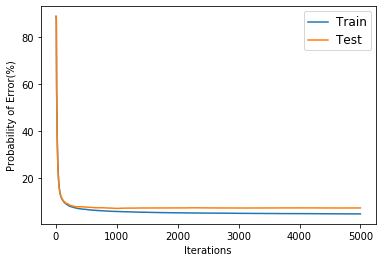

In [6]:
plt.plot(range(1,len(error_train_list)+1),error_train_list,label='Train')
plt.plot(range(1,len(error_test_list)+1),error_test_list,label='Test')
plt.xlabel('Iterations')
plt.ylabel('Probability of Error(%)')
legend=plt.legend()
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth('1.5')
plt.savefig('sigmoid_with_reg')